In [2]:
# # aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [3]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import boto3
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from guara.modeling.supervised_modelz import SupervisedModelz

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load data

In [4]:
# carregar dataset Laudo_classificacao_2020.xlsx como df
df =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Laudo_classificacao_2020.xlsx')
df.columns = df.columns.str.lower()
df.rename(columns={'(1) câncer / (2) não câncer':'cancer', 'texto_diagnostico_resumo':'resumo'}, inplace=True)

In [5]:
df.head()

,rgh,identificador,laudo,data,resumo,cancer
0,1341,3004888942H20-028890,H20-028890,2020-11-12,[* Pólipo endometrial sem atipias.],2
1,3166,3003664904H20-013662,H20-013662,2020-06-29,[*Adenocarcinoma endometrioide de endométrio c...,1
2,3166,2003793224H20-014936,H20-014936,2020-07-20,[* Adenocarcinoma endometrioide do endométrio ...,1
3,4448,3004533927H20-024222,H20-024222,2020-10-07,"[* Pólipo endocervical sem atipias., * Pólipo ...",2
4,6220,1003913311H20-016310,H20-016310,2020-07-31,[* Pólipo endocervical sem atipias com metapla...,2


In [6]:
# lendo datasets atualizados
laudos_list=[]

s3 = boto3.resource('s3', region_name='us-east-1', verify=False)
bucket = s3.Bucket('br-accamargo-rawdata-dev')

for files in bucket.objects.filter(Prefix='laudos_novo/LAUDOS'):
    laudos_list.append(wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/'+str(files.key)))

In [7]:
# concatenação dos datasets atualizados
laudos = pd.concat(laudos_list, axis=0)
laudos.columns = laudos.columns.str.lower()
laudos.rename(columns={'testodiagnosi':'texto','codigo_interno':'laudo'}, inplace=True)
laudos.drop_duplicates(inplace=True)
print(laudos.info())
laudos.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213318 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   laudo                 213318 non-null  string
 1   rgh                   213316 non-null  string
 2   dataliberacao         213318 non-null  string
 3   descrizione           213318 non-null  string
 4   codice                213318 non-null  string
 5   texto                 213314 non-null  string
 6   testodiagnosicitotec  0 non-null       string
dtypes: string(7)
memory usage: 13.0 MB
None


,laudo,rgh,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,H18-000071,15354940,04/01/2018,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia de pulmão: * Carcinoma epidermóide ...,<NA>
1,H18-000072,13832650,05/01/2018,BIOPSIA,BIO,1 Biópsia de lesão em amígdala direita: * P...,<NA>
2,H20-003157,13832650,04/02/2020,BIOPSIA,BIO,1 Biópsia de pele em peitoral esquerdo: * N...,<NA>
3,H18-000396,15360500,09/01/2018,BIOPSIA,BIO,1 Biópsia de pulmão direito: * Adenocarcino...,<NA>
4,H19-001989,15079600,31/01/2019,PEÇA CIRÚRGICA,PC,1 Esvaziamento cervical nível II B à direita ...,<NA>


<AxesSubplot:>

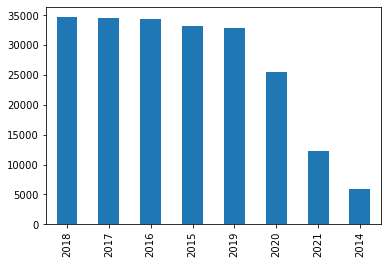

In [8]:
laudos.dataliberacao.apply(lambda x: x[-4:]).value_counts().plot(kind = 'bar')

In [9]:
# juntar df e laudos pela coluna laudo
full_df = pd.merge(left=df, right=laudos, on=['laudo'], how='inner')

In [10]:
# filtrar o dataframe: colunas = [df.id, laudo.laudo, df.rotulo]
full_df = full_df#[['laudo','texto','cancer']]
full_df['cancer'] = abs(full_df['cancer']-2)
full_df.head()

,rgh_x,identificador,laudo,data,resumo,cancer,rgh_y,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,1341,3004888942H20-028890,H20-028890,2020-11-12,[* Pólipo endometrial sem atipias.],0,1341,12/11/2020,PEÇA CIRÚRGICA,PC,1 Biópsia de pólipo endometrial: * Pólipo end...,<NA>
1,3166,3003664904H20-013662,H20-013662,2020-06-29,[*Adenocarcinoma endometrioide de endométrio c...,1,3166,29/06/2020,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia de endométrio (SPA20-26515): *Adenoca...,<NA>
2,3166,2003793224H20-014936,H20-014936,2020-07-20,[* Adenocarcinoma endometrioide do endométrio ...,1,3166,20/07/2020,PER-OPERATÓRIO PEÇA CIRÚRGICA,CONG_PEÇA,Útero: Corpo uterino: * Adenocarcinoma endom...,<NA>
3,4448,3004533927H20-024222,H20-024222,2020-10-07,"[* Pólipo endocervical sem atipias., * Pólipo ...",0,4448,07/10/2020,PEÇA CIRÚRGICA,PC,1 Pólipo de canal endocervical: * Pólipo endo...,<NA>
4,6220,1003913311H20-016310,H20-016310,2020-07-31,[* Pólipo endocervical sem atipias com metapla...,0,6220,31/07/2020,PEÇA CIRÚRGICA,PC,1 Pólipo de canal endocervical: * Pólipo endo...,<NA>


In [11]:
full_df.data.dt.year.value_counts()

2020    6806
Name: data, dtype: int64

# Analise Exploratória

In [12]:
full_df[['texto', 'resumo']].head().values

array([['1 Biópsia de pólipo endometrial:\r\n* Pólipo endometrial sem atipias.',
        '[* Pólipo endometrial sem atipias.]'],
       ['Biópsia de endométrio (SPA20-26515):\r\n*Adenocarcinoma endometrioide de endométrio com áreas de diferenciação escamosa e mucinosa.\r\n-Grau nuclear: 2\r\n-Grau arquitetural: 1\r\n-Grau histológico final (FIGO): 1\r\n\r\nImuno-histoquímica realizada no laboratório de origem:\r\nMaterial: Tumor de endométrio (SPA20-26515)\r\nIdentificação do bloco: H20-013662\r\nHipótese: Avaliação da expressão das proteínas dos genes de reparo do DNA\r\n\r\nA expressão dos seguintes antígenos foi pesquisada no material discriminado, utilizando-se o método HRP polimérico livre de biotina, com os seguintes resultados:\r\n\r\nMSH-2: positivo nas células neoplásicas.\r\nMSH-6: positivo nas células neoplásicas.\r\nMLH-1: positivo nas células neoplásicas.\r\nPMS-2: positivo nas células neoplásicas.\r\n\r\nCONCLUSÃO: Não há perda de expressão das proteínas dos genes de repa

# Modelagem

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [14]:
import nltk
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.misc import babelize_shell
from unidecode import unidecode
from nltk import tokenize

def processa_texto_(texto, return_ = 'string'):
    # stemmer = nltk.stem.RSLPStemmer()
    stemmer = nltk.stem.SnowballStemmer(language = 'portuguese')
    stopwords=nltk.corpus.stopwords.words('portuguese')
   


    # separa em palavras
    token = tokenize.word_tokenize(texto.lower(), language='portuguese')
    # retira stopwords
    token = [word for word in token if word not in stopwords]
    # retira palavras pre selecionadas
    #token = [word for word in token if len(word) > 2]
    # retira numeros 
    token = [ word if word.isalpha() else '#NUM' for word in token ]
    # tira caracteres especiais  e faz stemmizacao
    token = [unidecode(stemmer.stem(word)) for word in token]



    if return_ == 'string':
        return ' '.join(token)
    elif return_ == 'list':
        return token

    
class ProcessaTexto(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col=col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
     
        X['texto_tratado'] = X[self.col].replace('\§', ' ENTER ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '-'], '', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '\*'], ' ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace([ '\/', '\.', '\,', '\;'], ' punkt ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].apply(lambda x: processa_texto_(x))
        
        return X

In [15]:
class CountVectorizerPandas(BaseEstimator, TransformerMixin):
    """
    Performs bag of words on a column
    args:
        max_features: maximum number of features
    
    """  
    
    def __init__(self, max_features):
        self.cv = None
        self.max_features = max_features
        
    def fit(self, X, y=None):
        
        self.col = 'texto_tratado'
        
        self.cv =  CountVectorizer(max_features=self.max_features)
                           
        self.cv.fit(X[self.col])
        
        return self


    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        
        Xt = self.cv.transform(X[self.col]).todense()
        Xt = pd.DataFrame(Xt, columns = self.cv.get_feature_names(), index=X.index)
        
        return Xt  

In [16]:
# split dos dados - 70% para treino e 30% para validação
x_train, x_test, y_train, y_test = train_test_split(
    full_df[['laudo','texto']], 
    full_df['cancer'], 
    train_size=0.7, 
    shuffle=True,
    random_state=123
    )


# aplicar pipeline com transformações
pipe = Pipeline([
    ('preproc', ProcessaTexto('texto')),
    ('bag', CountVectorizerPandas(max_features=250))
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [17]:
y_train.value_counts()/y_train.shape[0]

0    0.75
1    0.25
Name: cancer, dtype: float64

In [18]:
x_train.head()  

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
5130,0,0,0,0,0,0,2,0,0,0,...,0,1,2,0,0,0,0,0,0,0
2416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
1300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
x_test.head().values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 1]])

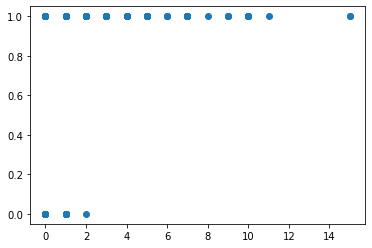

In [20]:
plt.scatter(x_train.carcinom, y_train)

In [21]:
carc = pd.DataFrame({'carcinoma':x_test.carcinom, 'cancer': y_test, 'count':[1]*len(y_test)})
carc.groupby([ 'cancer','carcinoma']).count()

count
cancer carcinoma       
0      0           1531
       1              3
       3              1
1      0            127
       1            254
       2             65
       3             14
       4              7
       5             27
       6              6
       7              6
       14             1

In [22]:
carc = pd.DataFrame({'neoplas':x_test.neoplas, 'cancer': y_test, 'count':[1]*len(y_test)})
carc.groupby([ 'cancer','neoplas']).count()

count
cancer neoplas       
0      0         1454
       1           43
       2           24
       3            4
       4            3
       5            1
       7            1
       10           1
       13           2
       14           2
1      0          172
       1           91
       2           77
       3           32
       4           40
       5           24
       6            9
       7           15
       8            9
       9            7
       10           3
       11           7
       12           4
       13           3
       14           4
       15           4
       16           2
       17           1
       19           3

In [23]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ', y_test.shape)

x_train shape:  (4764, 250) y_train shape:  (4764,)
x_test shape:  (2042, 250) y_test shape:  (2042,)


In [24]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

params = {
    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': 20,
    'n_estimators': 500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
 }

model = md.fit(x_train, x_test, y_train, y_test, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 1191, number of negative: 3573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 4764, number of used features: 250
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
Modelo treinado em 0.01 minutos 



Model best iteration: 500

BINARY_LOGLOSS loss:
Train: 0.0481
Val  : 0.0545


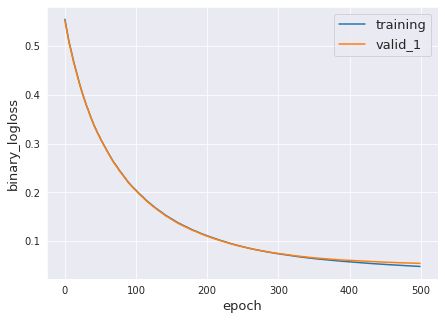

In [25]:
md.plot_train_info()

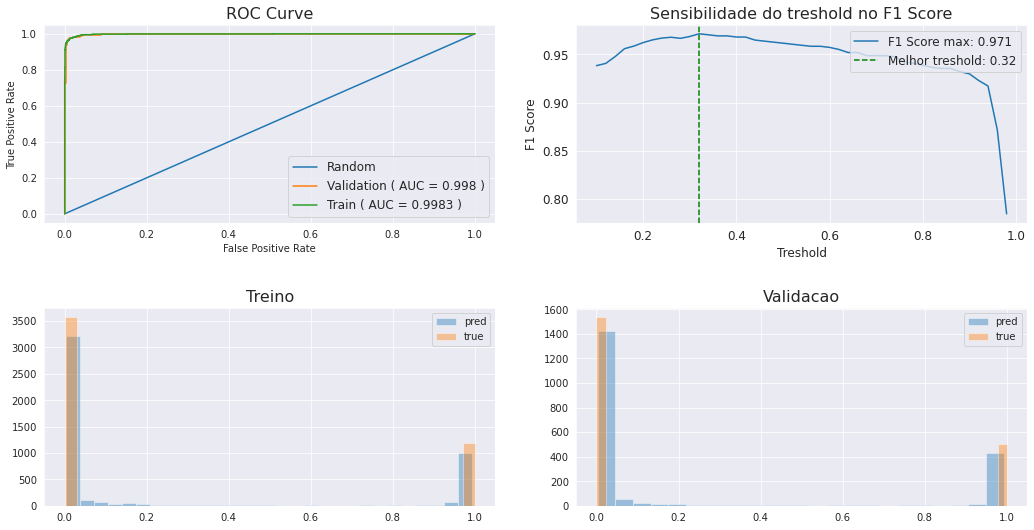

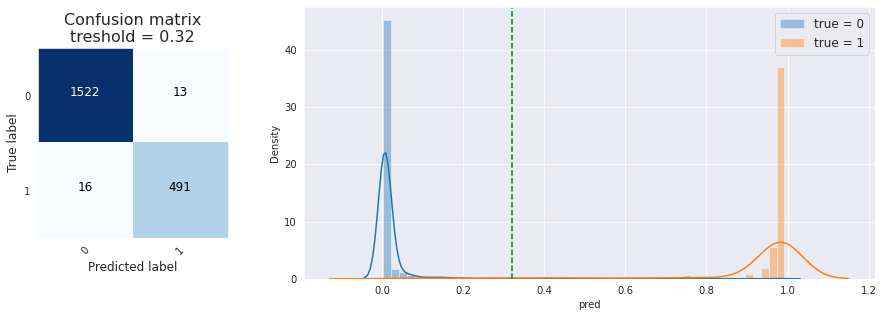


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1535
           1       0.97      0.97      0.97       507

    accuracy                           0.99      2042
   macro avg       0.98      0.98      0.98      2042
weighted avg       0.99      0.99      0.99      2042



In [26]:
ytrain_pred = md.predict(x_train)
yval_pred = md.predict(x_test)

md.evaluation_plots(y_train.values, ytrain_pred, y_test.values, yval_pred)

In [27]:
# shap
df_shap = md.init_shap(x_test)
df_shap.head()

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
0,0.0,0.000138,0.0,0.0,0.012412,-0.185823,-0.000210,0.0,0.008941,0.0,...,0.0,0.0,-0.000534,-0.019352,-0.000235,0.0,0.0,0.0,-0.001622,0.0
1,0.0,0.000138,0.0,0.0,0.002657,-0.182887,-0.000147,0.0,0.008389,0.0,...,0.0,0.0,-0.000418,-0.025218,-0.000326,0.0,0.0,0.0,-0.001651,0.0
2,0.0,0.000089,0.0,0.0,0.002386,-0.149104,-0.000147,0.0,0.009431,0.0,...,0.0,0.0,-0.000427,0.918198,-0.000326,0.0,0.0,0.0,-0.004118,0.0
3,0.0,0.000089,0.0,0.0,0.003073,-0.181912,-0.000183,0.0,0.010941,0.0,...,0.0,0.0,-0.000488,-0.016468,-0.000326,0.0,0.0,0.0,-0.001647,0.0
4,0.0,0.000509,0.0,0.0,0.002893,-0.056636,-0.000646,0.0,0.008855,0.0,...,0.0,0.0,0.020901,-0.004824,-0.000303,0.0,0.0,0.0,0.030471,0.0


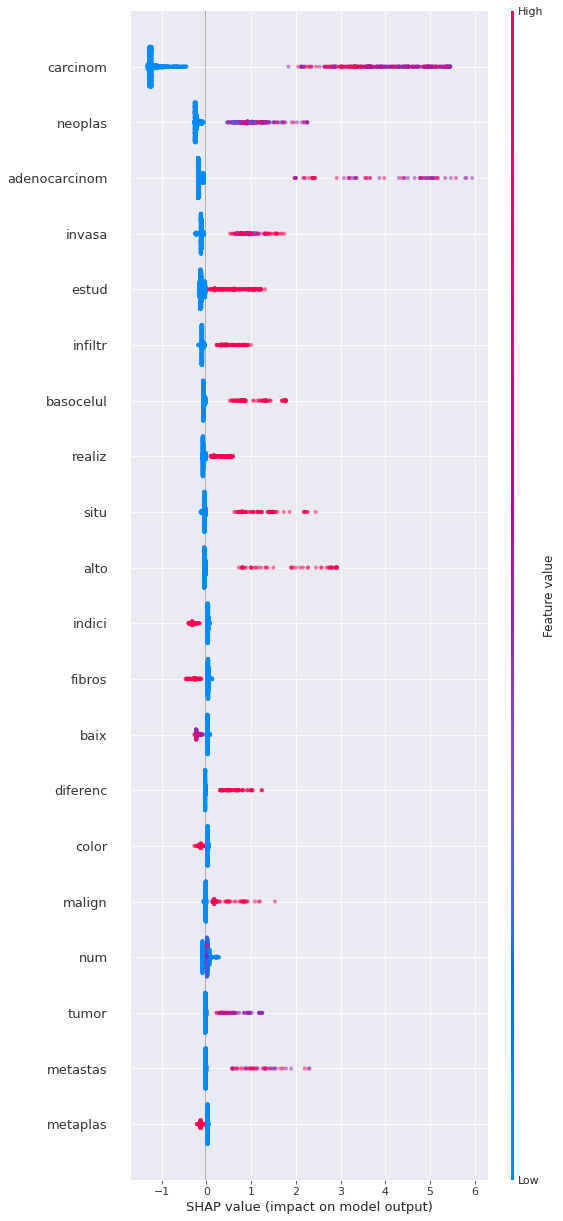

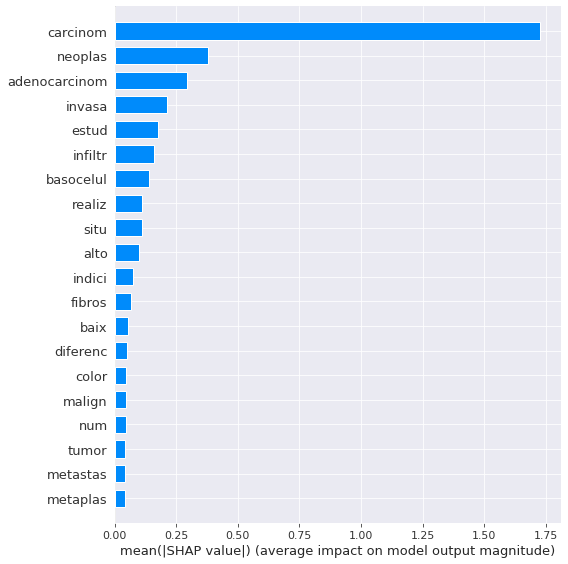

In [28]:
importance = md.shap_importance(x_test)

In [29]:
importance

carcinom         1.725975
neoplas          0.378428
adenocarcinom    0.291800
invasa           0.214171
estud            0.176145
                   ...   
intestinal       0.000000
intens           0.000000
inflamator       0.000000
hor              0.000000
acentu           0.000000
Length: 250, dtype: float64

# Verificação com dataset contendo laudos da categoria C

In [30]:
# lendo datasets atualizados
cver_list =[]

s3 = boto3.resource('s3', region_name='us-east-1', verify=False)
bucket = s3.Bucket('br-accamargo-rawdata-dev')

for files in bucket.objects.filter(Prefix='laudos_verificacao/LAUDOS'):
    cver_list.append(wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/'+str(files.key)))

In [31]:
# concatenação dos datasets atualizados
cver = pd.concat(cver_list, axis=0)
cver.columns = cver.columns.str.lower()
cver.rename(columns={'testodiagnosicitotec':'texto','codigo_interno':'laudo'}, inplace=True)
cver.drop_duplicates(inplace=True)
print(cver.info())
cver.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268875 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   laudo          268875 non-null  string
 1   rgh            268875 non-null  string
 2   dataliberacao  268875 non-null  string
 3   descrizione    268875 non-null  string
 4   codice         268875 non-null  string
 5   testodiagnosi  84278 non-null   string
 6   texto          180325 non-null  string
dtypes: string(7)
memory usage: 16.4 MB
None


,laudo,rgh,dataliberacao,descrizione,codice,testodiagnosi,texto
0,C17-024529,12461460,18/08/2017,CERVICO-VAGINAL (INTERNO),PAP_AMB,<NA>,DESCRIÇÃO DO ESPÉCIME: Número de Lâminas: 01 ...
1,C17-024530,14944320,18/08/2017,CERVICO-VAGINAL (INTERNO),PAP_AMB,<NA>,DESCRIÇÃO DO ESPÉCIME: Número de Lâminas: 01 ...
2,C17-024531,12461470,18/08/2017,CERVICO-VAGINAL (INTERNO),PAP_AMB,<NA>,DESCRIÇÃO DO ESPÉCIME: Número de Lâminas: 01 ...
3,C17-024532,13936480,22/08/2017,CERVICO-VAGINAL (INTERNO),PAP_AMB,<NA>,DESCRIÇÃO DO ESPÉCIME: Número de Lâminas: 01 ...
4,C17-024533,15094870,22/08/2017,CITOLOGIA PUNÇÃO,CITO_PUN,<NA>,1 Citologia de punção aspirativa por agulha fi...


In [32]:
cver[['texto']].head().values

array([['DESCRIÇÃO DO ESPÉCIME:\x0bNúmero de Lâminas: 01\r\nColoração: Papanicolaou\r\nMotivo: Rotina Preventiva\r\n\r\nADEQUABILIDADE DA AMOSTRA: \r\nSatisfatória\r\n\x0bEPITÉLIOS REPRESENTADOS NA AMOSTRA:\x0bEscamoso\x0b\x0bMICROBIOLOGIA:\x0bFlora ausente\r\n\x0bDIAGNÓSTICO DESCRITIVO:\x0bAlterações celulares benignas reativas ou reparativas:\x0bInflamação\x0b\r\n'],
       ['DESCRIÇÃO DO ESPÉCIME:\x0bNúmero de Lâminas: 01\r\nColoração: Papanicolaou\r\nMotivo: Rotina Preventiva\r\n\r\nADEQUABILIDADE DA AMOSTRA: \r\nSatisfatória\r\n\x0bEPITÉLIOS REPRESENTADOS NA AMOSTRA:\x0bEscamoso\x0b\x0bMICROBIOLOGIA:\x0bLactobacillus sp\x0b\x0bATIPIAS EM CÉLULAS ESCAMOSAS\x0bLesão intra-epitelial de alto grau (compreendendo efeito citopático pelo HPV e neoplasia intra-epitelial cervical graus II e III).\x0b\r\n'],
       ['DESCRIÇÃO DO ESPÉCIME:\x0bNúmero de Lâminas: 01\r\nColoração: Papanicolaou\r\nMotivo: Rotina Preventiva\r\n\r\nADEQUABILIDADE DA AMOSTRA: \r\nSatisfatória\r\n\x0bEPITÉLIOS REPRE

In [33]:
# data preparation
cver = cver[['texto']]
cver.dropna(inplace=True)
x_ver = pipe.transform(cver)
x_ver

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# percentage of true values for verification dataset
yver_pred = md.predict(x_ver)
true_list_reference = np.where(yver_pred >=0.32)
print('true index list: ', true_list_reference)
pst_percentage = len(true_list_reference[0])/len(yver_pred)
print('porcentagem de positivos: ', pst_percentage*100, ' %')

true index list:  (array([     1,     19,     20, ..., 180100, 180178, 180293]),)
porcentagem de positivos:  4.626646333009844  %


In [35]:
# exemplos de labels negativos 
print('exemplos de resultados negativos no dataset de verificação: \n \n')
for i in range(5,10):
    print(cver['texto'].iloc[i], '\n')

exemplos de resultados negativos no dataset de verificação: 
 

DESCRIÇÃO DO ESPÉCIME:Número de Lâminas: 01
Coloração: Papanicolaou
Motivo: Rotina Preventiva

ADEQUABILIDADE DA AMOSTRA: 
Satisfatória
EPITÉLIOS REPRESENTADOS NA AMOSTRA:EscamosoMetaplásicoMICROBIOLOGIA:Flora ausente
CÉLULAS ATÍPICAS DE SIGNIFICADO INDETERMINADOEscamosasPossivelmente não neoplásicas (ASC-US)
 

DESCRIÇÃO DO ESPÉCIME:Número de Lâminas: 01
Coloração: Papanicolaou
Motivo: Rotina Preventiva

ADEQUABILIDADE DA AMOSTRA: 
Satisfatória
EPITÉLIOS REPRESENTADOS NA AMOSTRA:EscamosoMICROBIOLOGIA:Lactobacillus spDIAGNÓSTICO DESCRITIVO:Dentro dos limites da normalidade, no material examinado.

 

DESCRIÇÃO DO ESPÉCIME:Número de Lâminas: 01
Coloração: Papanicolaou
Motivo: Rotina Preventiva

ADEQUABILIDADE DA AMOSTRA: 
Satisfatória
EPITÉLIOS REPRESENTADOS NA AMOSTRA:EscamosoMICROBIOLOGIA:Lactobacillus spCÉLULAS ATÍPICAS DE SIGNIFICADO INDETERMINADOEscamosasPossivelmente não neoplásicas (ASC-

In [36]:
# exemplos de labels positivos 
print('exemplos de resultados positivos no dataset de verificação: \n \n')
for i in range(5):
    print(cver['texto'].iloc[true_list_reference[0][i]], '\n')

exemplos de resultados positivos no dataset de verificação: 
 

DESCRIÇÃO DO ESPÉCIME:Número de Lâminas: 01
Coloração: Papanicolaou
Motivo: Rotina Preventiva

ADEQUABILIDADE DA AMOSTRA: 
Satisfatória
EPITÉLIOS REPRESENTADOS NA AMOSTRA:EscamosoMICROBIOLOGIA:Lactobacillus spATIPIAS EM CÉLULAS ESCAMOSASLesão intra-epitelial de alto grau (compreendendo efeito citopático pelo HPV e neoplasia intra-epitelial cervical graus II e III).
 

DESCRIÇÃO DO ESPÉCIME:Número de Lâminas: 01
Coloração: Papanicolaou
Motivo: Rotina Preventiva

ADEQUABILIDADE DA AMOSTRA: 
Satisfatória
EPITÉLIOS REPRESENTADOS NA AMOSTRA:EscamosoGlandularMetaplásicoMICROBIOLOGIA:Lactobacillus spCÉLULAS ATÍPICAS DE SIGNIFICADO INDETERMINADOEscamosasNão se pode afastar lesão de alto grau (ASC-H)
 


1 Punção aspirativa por agulha fina de parótida direita

Características do espécime:
	Tipo do espécime: citologia convencional
	Topografia: parótida direita

Número de lâminas confeccionadas:
	Esfregaços dir